# NLP Project Anaïs Malet : Predict TripAdvisor Reviews Rating 

### Content

This dataset consisting of 20k reviews crawled from Tripadvisor.

### Goal

The whole goal of the project is to predict how many stars gets a hotel based on client reviews.

### Credits

Tripadvisor Hotel Review Dataset file, from the publication:

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.

## Notebook 4 : Deep learning

We will try 4 types of Deep Learning models:

- Simple Neural Network
- RNN
- LSTM
- CNN

For each of this model, we will use a Tokenizer to encode the input. We ill use Adam as optimizer and binary_crossentropy as loss function. We also implemented an early stopper to avoid overfitting.

In [2]:
# Import librairies
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import tensorflow.compat.v1 as tf
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
pd.options.mode.chained_assignment = None
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Load and read data


In [3]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
print(f"Number of rows : {df.shape[0]}\nNumber of columns : {df.shape[1]}")
df

Number of rows : 20491
Number of columns : 2


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


## ***Train/test split***

### Encoding labels

We want to encode the class labels and create a train/test split

In [4]:
# instantiate a label encoder # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
label_encoder = LabelEncoder()

# fit and transform the encoder on labels
df['Review_enc'] = label_encoder.fit_transform(df['Rating'])

### Split and Vectorize

In [5]:
# Define class labels
class_labels = ["1 star","2 stars","3 stars","4 stars","5 stars"]
category_orders = {"Review": class_labels}

# Split the data into training and testing sets
X = df['Review']
y = df['Review_enc']

# Assuming 'X' is your text data and 'y' is the corresponding labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Build a simple neurone network 

Here's the components we will use, adapted for our multi-class dataset :

### 1. Output Layer Activation:
 **'softmax'**, a common choice for multi-class classification problems. It transforms the raw model output into probability distributions over the different classes.

### 2. Loss Function:
 **'sparse_categorical_crossentropy'**. This loss function is suitable for multi-class classification problems when the labels are integers.

### 3. Evaluation: 
**'model.evaluate'**. The accuracy metric is used to assess the model's performance on the test set.

### 4. Optimizer:
**'Adam'**. The Adam optimization algorithm is a popular choice for training neural networks due to its effectiveness in practice. It might not always be the best optimizer for every situation. Depending on our dataset, and architecture, we might want to experiment with other optimizers such as SGD (Stochastic Gradient Descent), RMSProp, or others.

### 5. The Embedding layer:

This layer is used for word embedding, and we need to compute its attributes :

#### - Input_dim: 

This is the size of our vocabulary which is the total number of unique words in your dataset. We will use a tokenizer, so it would be len(tokenizer.word_index) + 1.

Compute 'input_dim' as 'max_words' :

In [6]:
# Use the Counter class to return the most frequent words
cnt = Counter()

# Join all the text in the text_wo_stop column using the join() function
joined_text = " ".join(X)

# Tokenize the text by using the split() function
split = joined_text.split()

# Instantiate the Counter class with your tokenized array
word_counter = Counter(split)

# Use the most_common class method to return the most frequent words
most_common = word_counter.most_common()

max_words = len(most_common)

print('Max_words = '+ str(max_words))

Max_words = 102008


#### - Input_length: 

The number of words in each sequence. This should be the length of our input sequences, which is the maximum number of words in a sentence or document. Our sentences are of variable length,so we will pad them to a fixed length. Compute 'max_sentence_length' : the maximum number of words in a sentence

The maximum length of a sentence : max_sentence_length = 1931


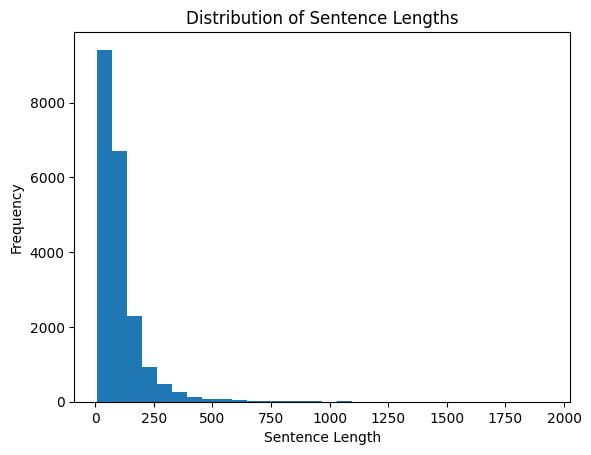

In [7]:
# Assuming X is a list of preprocessed text data
sentence_lengths = [len(sentence.split()) for sentence in X]

# Find the maximum length of a sentence
max_sentence_length = max(sentence_lengths)

# Display the result
print(f"The maximum length of a sentence : max_sentence_length = {max_sentence_length}")

# Plot the histogram
plt.hist(sentence_lengths, bins=30)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sentence Lengths')
plt.show()

#### - Output_dim: 

The output_dim is the number of dimensions in the embedding vector. 
A higher output_dim allows the model to learn more intricate relationships between words but may increase the computational cost.

For smaller datasets or simpler tasks, we might use a smaller output_dim, such as 50 or 100.

For larger datasets or more complex tasks, we should consider using a larger output_dim, such as 200 or 300.

We will set our Output_dim between small and large dataset : 150

In [8]:
output_dim = 150


## Define the simple neural network with Keras

Now, we've choose our hyperparameters and layers we can build our simple neural network. 

And let's tune the 'epochs' parameter.

- With 'epochs' = 5 we have an accuracy of 0,56
- With 'epochs' = 10 we have an accuracy of 0,58

Let's try with 'epochs' = 50 to might see better results.

In [9]:
from tensorflow.keras.utils import to_categorical

# One-hot encode ratings
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

input_dim = len(tokenizer.word_index) + 1

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sentence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sentence_length)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_sentence_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(len(set(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



Epoch 1/50
461/461 [==============================] - 423s 907ms/step - loss: 1.1504 - accuracy: 0.4966 - val_loss: 0.9155 - val_accuracy: 0.5817
Epoch 2/50
461/461 [==============================] - 324s 700ms/step - loss: 0.6950 - accuracy: 0.7047 - val_loss: 0.8913 - val_accuracy: 0.6091
Epoch 3/50
461/461 [==============================] - 314s 682ms/step - loss: 0.2479 - accuracy: 0.9074 - val_loss: 1.4157 - val_accuracy: 0.6030
Epoch 4/50
461/461 [==============================] - 310s 673ms/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 2.1515 - val_accuracy: 0.5659
Epoch 5/50
461/461 [==============================] - 316s 685ms/step - loss: 0.0161 - accuracy: 0.9957 - val_loss: 2.6543 - val_accuracy: 0.5939
Epoch 6/50
461/461 [==============================] - 311s 675ms/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 2.3861 - val_accuracy: 0.5915
Epoch 7/50
461/461 [==============================] - 313s 678ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 2.8490 -

In summary, after increasing the number of training epochs to 50, the neural network exhibited a notable improvement in accuracy, achieving a higher accuracy rate of 0.59. However, this advancement came at the cost of a significantly extended training duration. The decision to balance between training time and model performance is crucial and should be made based on the specific requirements of the application. Further optimization strategies or exploration of alternative neural network architectures may be considered to strike a balance between achieving a satisfactory accuracy and maintaining a reasonable computational efficiency.